## This is a RandomForestClassifier model with the best parameters found using k-fold cross-validation to find better hyperparameters. The columns pertaining to player id and player name were removed to try and reduce overfitting

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
df = pd.read_csv('../Resources/matches_cleaned.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,player_id,player_seed,player_name,...,player_bpSaved,player_bpFaced,player_rank,player_rank_points,set_1_score,set_2_score,set_3_score,set_4_score,set_5_score,winner
0,2023-7696,NextGen Finals,Hard,8,F,2023-11-27,300,209098.0,6.0,Hamad Medjedovic,...,4.0,4.0,110.0,582.0,3.0,4.0,4.0,3.0,4.0,1
1,2023-7696,NextGen Finals,Hard,8,F,2023-11-27,300,209950.0,1.0,Arthur Fils,...,1.0,4.0,36.0,1158.0,4.0,1.0,2.0,4.0,1.0,0
2,2023-7696,NextGen Finals,Hard,8,F,2023-11-27,299,209950.0,1.0,Arthur Fils,...,2.0,3.0,36.0,1158.0,2.0,4.0,4.0,4.0,NaN,1
3,2023-7696,NextGen Finals,Hard,8,F,2023-11-27,299,209414.0,2.0,Luca Van Assche,...,2.0,3.0,70.0,756.0,4.0,1.0,3.0,3.0,NaN,0
4,2023-7696,NextGen Finals,Hard,8,F,2023-11-27,298,209098.0,6.0,Hamad Medjedovic,...,0.0,0.0,110.0,582.0,4.0,2.0,NaN,NaN,NaN,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76434 entries, 0 to 76433
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          76434 non-null  object 
 1   tourney_name        76434 non-null  object 
 2   surface             76434 non-null  object 
 3   draw_size           76434 non-null  int64  
 4   tourney_level       76434 non-null  object 
 5   tourney_date        76434 non-null  object 
 6   match_num           76434 non-null  int64  
 7   player_id           76434 non-null  float64
 8   player_seed         27936 non-null  float64
 9   player_name         76434 non-null  object 
 10  player_hand         76434 non-null  object 
 11  player_ht           75798 non-null  float64
 12  player_ioc          76434 non-null  object 
 13  player_age          76432 non-null  float64
 14  score               76434 non-null  object 
 15  best_of             76434 non-null  int64  
 16  roun

In [4]:
# drop unwanted columns
columns_to_drop = ['tourney_id', 'tourney_date', 'tourney_name', 'match_num', 'player_seed', 'score', 'set_3_score', 'set_4_score', 'set_5_score', 'draw_size', 'player_id', 'player_name', 
                   'player_rank_points']
df.drop(columns=columns_to_drop, inplace=True)

In [5]:
# check columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76434 entries, 0 to 76433
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   surface         76434 non-null  object 
 1   tourney_level   76434 non-null  object 
 2   player_hand     76434 non-null  object 
 3   player_ht       75798 non-null  float64
 4   player_ioc      76434 non-null  object 
 5   player_age      76432 non-null  float64
 6   best_of         76434 non-null  int64  
 7   round           76434 non-null  object 
 8   minutes         73082 non-null  float64
 9   player_ace      75788 non-null  float64
 10  player_df       75788 non-null  float64
 11  player_svpt     75788 non-null  float64
 12  player_1stIn    75788 non-null  float64
 13  player_1stWon   75788 non-null  float64
 14  player_2ndWon   75788 non-null  float64
 15  player_SvGms    75790 non-null  float64
 16  player_bpSaved  75788 non-null  float64
 17  player_bpFaced  75788 non-null 

In [6]:
# features set
X = df.copy()
targets = ['tourney_id']
X.drop('winner', axis=1, inplace=True)

# target vector
y = df['winner']

In [7]:
# lists for categorical and numeric features to standardize and encode
cat_features = ['surface', 'tourney_level', 'player_hand', 'player_ioc', 'best_of', 'round']
num_features = ['player_ht', 'player_age', 'minutes', 'player_ace', 'player_df', 'player_svpt', 'player_1stIn', 'player_1stWon', 'player_2ndWon', 'player_SvGms', 'player_bpSaved',
                'player_bpFaced', 'player_rank', 'set_1_score', 'set_2_score']

In [8]:
# imports
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())
])

# categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# preprocessor from both transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

# create random forest classifier model after preprocessing
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=0))
    ]
)

In [9]:
# split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [10]:
# parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': [2, 4, 6, 8, 10],
    'classifier__criterion': ['gini', 'entropy']
}

In [11]:
# import GridSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1, verbose=1, scoring='accuracy')

# Train the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

Fitting 5 folds for each of 150 candidates, totalling 750 fits


c:\Users\K\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
250 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
195 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\K\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\K\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\K\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **las

Best parameters found: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 400}


In [12]:
# use the best parameters for the pipeline
pipeline_best = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', RandomForestClassifier(**{
                                    'n_estimators': best_params['classifier__n_estimators'],
                                    'max_features': best_params['classifier__max_features'],
                                    'max_depth': best_params['classifier__max_depth'],
                                    'criterion': best_params['classifier__criterion'],
                                    'random_state': 0
                                }))])

In [13]:
model = pipeline_best.fit(X_train, y_train)

In [14]:
predictions = model.predict(X_test)

In [15]:
# evaluate model
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

proba_predictions = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, proba_predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'\nClassification Report:\n{classification_report(y_test, predictions)}')

# add scores to df
scores_df = pd.read_csv('../Resources/model_scores.csv')

new_scores = {
        'version': '3',
        'accuracy': round(accuracy, 2),
        'precision': round(precision, 2),
        'recall': round(recall, 2),
        'f1': round(f1, 2),
        'roc_auc': round(roc_auc, 2),
    }

new_scores_df = pd.DataFrame(new_scores, index=[0])
updated_scores_df = pd.concat([scores_df, new_scores_df], ignore_index=True)

                            
updated_scores_df.to_csv('../Resources/model_scores.csv', index=False)

Accuracy: 0.84
Precision: 0.86
Recall: 0.81
F1-Score: 0.83
ROC AUC: 0.94
Confusion Matrix:
[[8282 1265]
 [1805 7757]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      9547
           1       0.86      0.81      0.83      9562

    accuracy                           0.84     19109
   macro avg       0.84      0.84      0.84     19109
weighted avg       0.84      0.84      0.84     19109



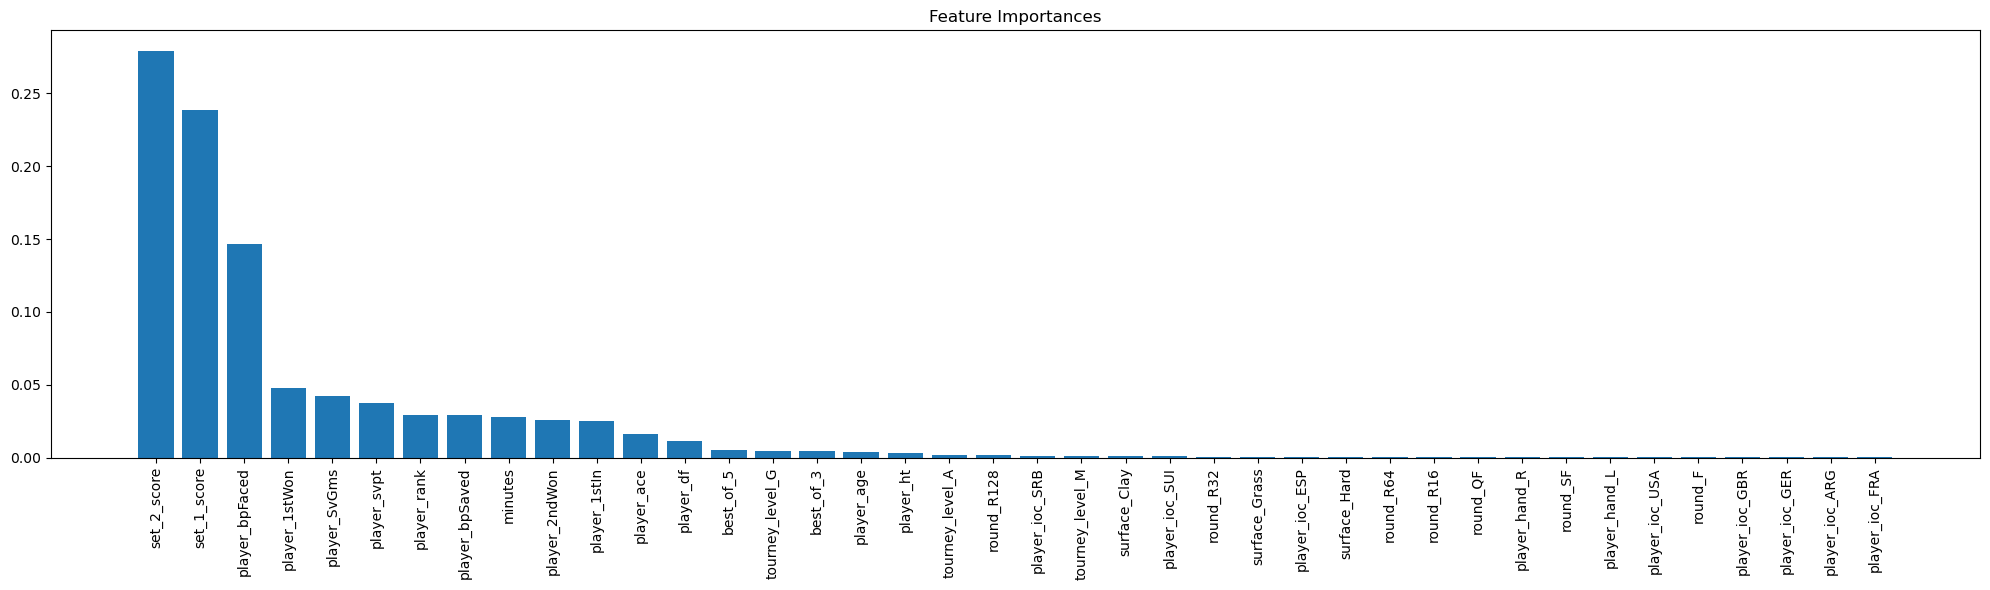

In [16]:
# check feature importance
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances from the best model
importances = model.named_steps['classifier'].feature_importances_
feature_names = num_features + list(model.named_steps['preprocessor'].transformers_[1][1]['encoder'].get_feature_names_out(cat_features))
indices = np.argsort(importances)[-40:][::-1]

# Plot the feature importances
plt.figure(figsize=(20, 6))
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()